In [1]:
import numpy as np
import tensorflow as tf
import flowpm
import tensorflow_probability as tfp

In [25]:
cosmo={"w0":-1.0,
       "wa":0.0,
       "H0":100,
       "h":0.6774,
       "Omega0_b":0.04860,
       "Omega0_c":0.2589,
       "Omega0_m":0.3075,
       "Omega0_k":0.0,
       "Omega0_de":0.6925,
       "n_s":0.9667,
       "sigma8":0.8159}

In [26]:
def fde(cosmo,a,epsilon=1e-5):
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    w0=tf.convert_to_tensor(cosmo["w0"],dtype=tf.float32)
    wa=tf.convert_to_tensor(cosmo["wa"],dtype=tf.float32)
    return (-3.0*(1.0+w0)+
            3.0*wa*((a-1.0)/tf.math.log(a-epsilon)-1.0))

In [27]:
def w(cosmo,a):
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    w0=tf.convert_to_tensor(cosmo["w0"],dtype=tf.float32)
    wa=tf.convert_to_tensor(cosmo["wa"],dtype=tf.float32)
    return w0+wa*(1.0-a)


In [28]:
def E(cosmo,a):
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    return(tf.math.sqrt(
        cosmo["Omega0_m"]/tf.math.pow(a, 3)
        +cosmo["Omega0_k"]/tf.math.pow(a, 2)
        +cosmo["Omega0_de"]*tf.math.pow(a, fde(cosmo,a))))

In [29]:
def H(cosmo, a):
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    return cosmo["H0"]*cosmo["h"] *(E(cosmo, a))

In [30]:
def dfde(cosmo,a,epsilon=1e-5):
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    wa=tf.convert_to_tensor(cosmo["wa"],dtype=tf.float32)
    return (3*wa*
            (tf.math.log(a-epsilon)-(a-1)/(a-epsilon))
            /tf.math.pow(tf.math.log(a-epsilon),2))

In [31]:
def dEa(cosmo,a,epsilon=1e-5):
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    return 0.5*(-3*cosmo["Omega0_m"]/tf.math.pow(a, 4)-2*cosmo["Omega0_k"]/tf.math.pow(a, 3)
    +dfde(cosmo,a)*cosmo["Omega0_de"]*tf.math.pow(a, fde(cosmo,a)))
    


In [32]:
def Omega_m_a(cosmo,a):
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    return cosmo["Omega0_m"]*tf.math.pow(a,-3)/E(cosmo,a)**2

In [33]:
def Omega_de_a(cosmo,a):
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    return cosmo["Omega0_de"]*tf.math.pow(a,fde(cosmo,a))/E(cosmo,a)**2

In [34]:
log10_amin=-3
steps=128
atab =np.logspace(log10_amin, 0.0, steps)
y0=tf.constant([[atab[0], -3./7 * 0.001**2], [1.0, -6. / 7 *0.001]],dtype=tf.float32)

In [35]:
#Equation 1.96 from Florent Leclercq thesis

# @tf.function
# def growth_func(a,y):
#     y=tf.convert_to_tensor(y,dtype=tf.float32)
#     a=tf.convert_to_tensor(a,dtype=tf.float32)
#     d=y[0]
#     d_f=y[1]
#     dydt= d_f,1.5*Omega_m_a(cosmo,a)*d/tf.pow(a,2)-(d_f/a)*(Omega_de_a(cosmo,a)-0.5*Omega_m_a(cosmo,a)+2)
#     return dydt     

#Equation 1.96 from Florent Leclercq thesis
@tf.function
def growth_func(a,y):
    y=tf.convert_to_tensor(y,dtype=tf.float32)
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    d = y[0]
    d_f = y[1]
    # EXtracting d1 and derivative
    d1 = d[0]
    d1_f = d_f[0]
    # Extractinct d2 and derivative
    d2 = d[1]
    d2_f = d_f[1]
    # ODE for d1
    dy1dt= d1_f,1.5*Omega_m_a(cosmo,a)*d1/tf.pow(a,2)-(d1_f/a)*(Omega_de_a(cosmo,a)-0.5*Omega_m_a(cosmo,a)+2)
    # ODE for d2
    dy2dt = d2_f,1.5*Omega_m_a(cosmo,a)*d2/tf.pow(a,2)-(d2_f/a)*(Omega_de_a(cosmo,a)-0.5*Omega_m_a(cosmo,a)+2)  - 1.5*Omega_m_a(cosmo,a)*d1**2/tf.pow(a,2)   
    
    # Concatenate output
    dydt = [[dy1dt[0], dy2dt[0]], 
            [dy1dt[1], dy2dt[1]]]
    return dydt

In [36]:
@tf.function
def odesolve_func(atab,y0):
    solver=tfp.math.ode.BDF()
    results = solver.solve(growth_func,atab[0], y0, solution_times=atab)
    return results


In [37]:
results_func=odesolve_func(atab,y0)

Populating the interactive namespace from numpy and matplotlib


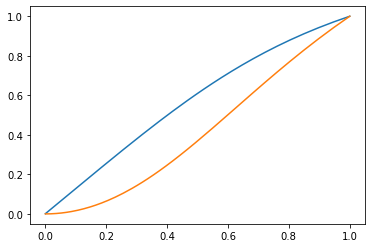

In [44]:
%pylab inline
plot(results_func.times,results_func.states[:,0,0]/results_func.states[-1,0,0])
plot(results_func.times,results_func.states[:,0,1]/results_func.states[-1,0,1])
#plot(results_func.times,results_func.states[:,0]/max(results_func.states[:,0]))
#savefig("growt_function.png",dpi=200)

In [16]:

#comparison with background.py

from flowpm.background import MatterDominated
M_d=MatterDominated(Omega0_m=0.3075)

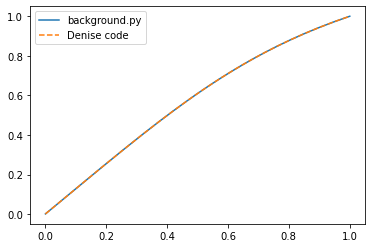

In [46]:
#comparison between background.py and growth_function  D1 plot
plot(results_func.times,M_d.D1(results_func.times), label='background.py')
plot(results_func.times,results_func.states[:,0,0]/results_func.states[-1,0,0],'--',label='Denise code')
legend()

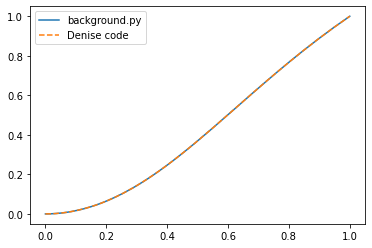

In [47]:
#comparison between background.py and growth_function D2 plot
plot(results_func.times,M_d.D2(results_func.times), label='background.py')
plot(results_func.times,results_func.states[:,0,1]/results_func.states[-1,0,1],'--',label='Denise code')
legend()

In [49]:
#comparison with jax_cosmo code
from jax_cosmo.background import growth_factor
from jax_cosmo.parameters import Planck15

In [50]:
cosmo=Planck15()


/Users/dl264294/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:6081: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/Users/dl264294/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:6081: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


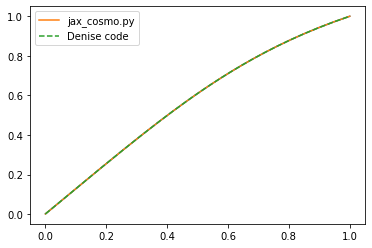

In [52]:
plot(atab,growth_factor(cosmo, atab))
plot(results_func.times,growth_factor(cosmo, atab), label='jax_cosmo.py')
plot(results_func.times,results_func.states[:,0,0]/results_func.states[-1,0,0],'--',label='Denise code')
legend()